# Proyek: Analisis Prediksi Biaya Medis
## Notebook 04: Modeling Risk Pool Clustering

**Fase CRISP-ML(Q):** 4. Modeling (Unsupervised), 5. Evaluation

**Tujuan:**
1.  Menggunakan pendekatan *unsupervised* (K-Means Clustering) untuk mengidentifikasi segmen nasabah (risk pools) alami.
2.  Kita akan memodelkan **hanya** berdasarkan fitur nasabah (`age`, `bmi`, `smoker`, dll.), seolah-olah kita tidak tahu `charges`-nya.
3.  Mengevaluasi cluster yang ditemukan dengan membandingkannya dengan `charges` yang sebenarnya untuk melihat apakah model berhasil memisahkan kelompok berbiaya rendah dan tinggi.

## 1. Setup & Pemuatan Data

Kita akan memuat *library* yang diperlukan dan data **MENTAH**.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Preprocessing (sama seperti sebelumnya)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import silhouette_score

# Definisikan path kita
RAW_DATA_PATH = '../data/raw/insurance.csv'

print("Libraries imported successfully!")

Libraries imported successfully!


In [35]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f"Data mentah loaded. Shape: {df_raw.shape}")

Data mentah loaded. Shape: (1338, 7)


## 2. Persiapan Data & Pipeline

Untuk clustering, kita menggunakan **semua data** (bukan train-test split). Kita ingin mengelompokkan seluruh populasi kita.

Kita akan menggunakan `ColumnTransformer` yang sama, tetapi kita akan memisahkannya dari `Pipeline` model agar kita bisa mendapatkan data yang sudah diproses untuk *scaling*.

In [36]:
# 1. Tentukan Fitur (X). KITA BUANG 'charges' DARI AWAL.
X = df_raw.drop(columns=['charges'])

# 2. Definisikan pipeline preprocessing kita (identik dengan NB 02 & 03)
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


In [37]:
# 3. Terapkan preprocessor ke SEMUA data X kita
print("Menerapkan preprocessing ke seluruh dataset...")
X_processed = preprocessor.fit_transform(X)

print(f"Data berhasil diproses. Shape baru: {X_processed.shape}")

Menerapkan preprocessing ke seluruh dataset...
Data berhasil diproses. Shape baru: (1338, 8)


## 3. Fase Modeling: Menemukan K Optimal

Kita akan menggunakan dua metode untuk menemukan jumlah cluster (K) yang optimal:
1.  **Elbow Method:** Mencari titik "siku" di mana WCSS (inertia) mulai melambat penurunannya.
2.  **Silhouette Score:** Mengukur seberapa baik cluster terpisah satu sama lain (skor lebih tinggi lebih baik, maks 1.0).

In [38]:
wcss = []
silhouette_scores = []
K_RANGE = range(2, 11) # K-Means butuh minimal 2 cluster

print("Menghitung WCSS dan Silhouette Scores untuk K=2 hingga 10...")

for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_processed, kmeans.labels_))

print("Perhitungan selesai.")

Menghitung WCSS dan Silhouette Scores untuk K=2 hingga 10...
Perhitungan selesai.


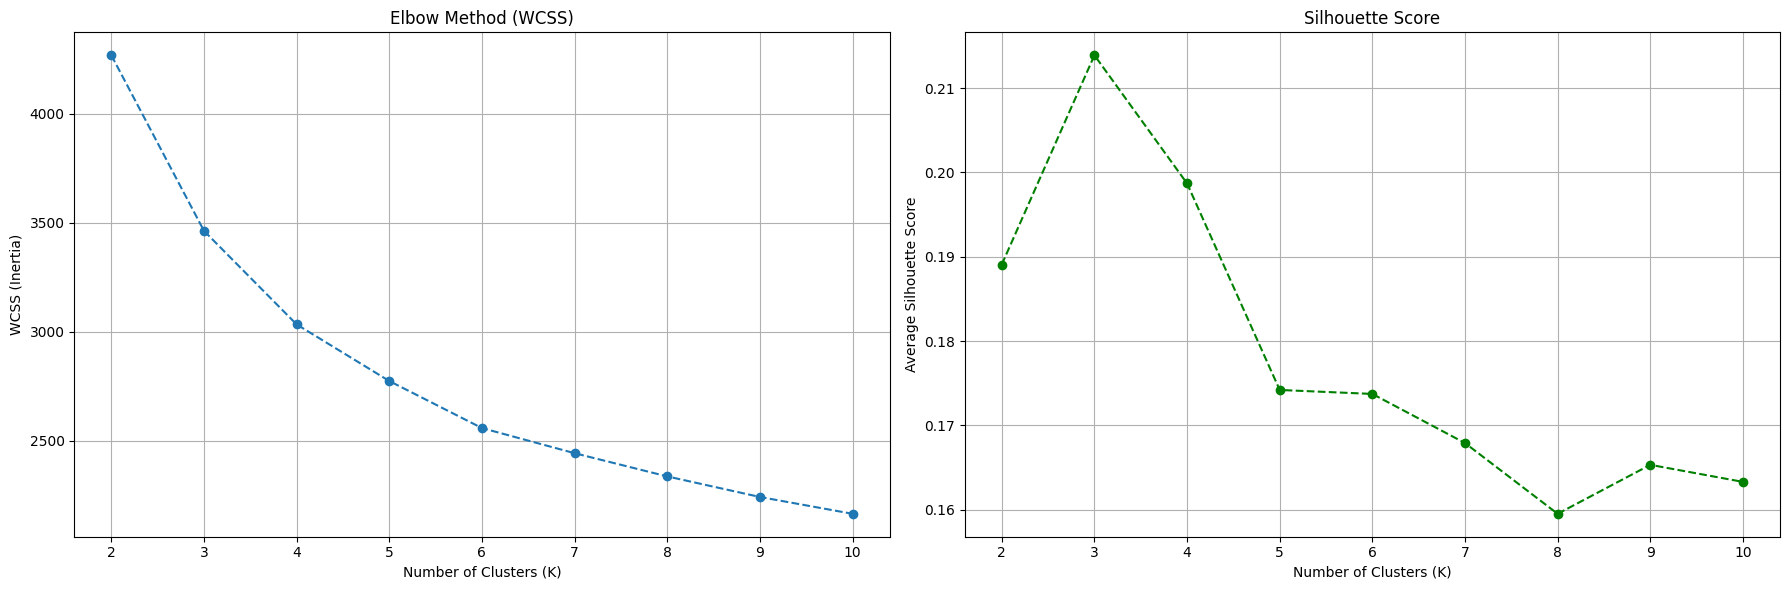

In [39]:
# Plot kedua metrik
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Elbow Method (WCSS)
ax1.plot(K_RANGE, wcss, marker='o', linestyle='--')
ax1.set_title('Elbow Method (WCSS)')
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('WCSS (Inertia)')
ax1.grid(True)

# Plot 2: Silhouette Score
ax2.plot(K_RANGE, silhouette_scores, marker='o', linestyle='--', color='green')
ax2.set_title('Silhouette Score')
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Average Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

**Temuan:**
Elbow Method benar menunjukkan siku yang landai. Namun, *Silhouette Score* akan memberi kita gambaran yang lebih jelas. Kita akan mencari **puncak** pada grafik Silhouette Score. Puncaknya ada di `K=3`.

Mari kita pilih `K=3` untuk analisis yang lebih mendalam.

In [40]:
# --- Nilai BERDASARKAN PLOT ---
OPTIMAL_K = 3
# ---------------------------------------------

print(f"Training final K-Means model with K={OPTIMAL_K}...")

# Latih model final dengan K optimal
kmeans_final = KMeans(n_clusters=OPTIMAL_K,
                      random_state=42,
                      n_init=10)

kmeans_final.fit(X_processed)
cluster_labels = kmeans_final.labels_

print("Final model trained successfully.")

Training final K-Means model with K=3...
Final model trained successfully.


## 4. Fase Evaluasi: Menganalisis Cluster

Ini adalah bagian terpenting. Kita akan mengambil `cluster_labels` (0, 1, 2, 3, 4) dan menambahkannya kembali ke DataFrame **mentah** (`df_raw`) kita.

Pertanyaannya: Apakah cluster-cluster ini, yang dibuat **tanpa** mengetahui `charges`, secara ajaib berhasil memisahkan nasabah berbiaya rendah dan tinggi?

In [41]:
# Tambahkan label cluster ke DataFrame mentah kita untuk evaluasi
df_analysis = df_raw.copy()
df_analysis['cluster'] = cluster_labels

print(df_analysis.head())

   age     sex     bmi  children smoker     region      charges  cluster
0   19  female  27.900         0    yes  southwest  16884.92400        1
1   18    male  33.770         1     no  southeast   1725.55230        1
2   28    male  33.000         3     no  southeast   4449.46200        0
3   33    male  22.705         0     no  northwest  21984.47061        1
4   32    male  28.880         0     no  northwest   3866.85520        1


In [42]:
# Mari kita lihat rata-rata 'charges' untuk setiap cluster
print("--- Rata-rata 'charges' per Cluster ---")
cluster_charges = df_analysis.groupby('cluster')['charges'].mean().sort_values()
print(cluster_charges)

--- Rata-rata 'charges' per Cluster ---
cluster
1     9454.000272
0    14795.552608
2    16056.909548
Name: charges, dtype: float64


### 4.1 Visualisasi Distribusi Biaya (Charges) per Cluster

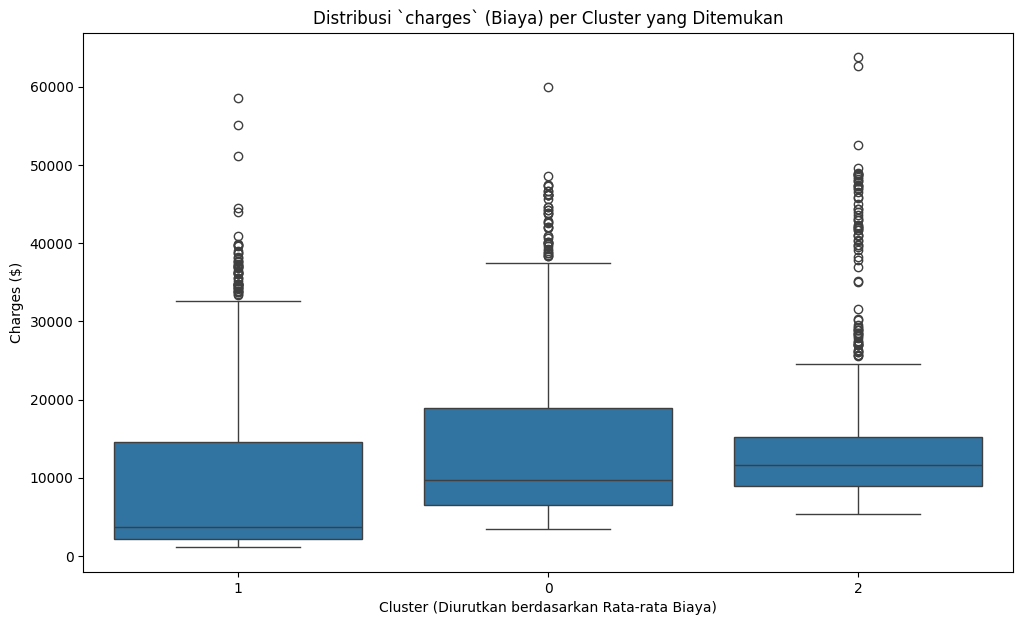

In [43]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='cluster', y='charges', data=df_analysis, order=cluster_charges.index)
plt.title('Distribusi `charges` (Biaya) per Cluster yang Ditemukan')
plt.xlabel('Cluster (Diurutkan berdasarkan Rata-rata Biaya)')
plt.ylabel('Charges ($)')

plt.show()

**Temuan Kunci (Evaluasi Bisnis):**
Jika *boxplot* di atas menunjukkan pemisahan yang jelas (misal, satu cluster memiliki `charges` rata-rata $30,000+ dan yang lain $5,000), maka model clustering kita **SUKSES**.

Ini membuktikan bahwa kita dapat mengidentifikasi *risk pools* hanya dari data demografis.

### 4.2 Menganalisis Persona Cluster

Mengapa cluster-cluster itu terpisah? Mari kita lihat demografi mereka.

In [44]:
# Buat tabel pivot untuk melihat karakteristik setiap cluster
cluster_analysis = df_analysis.groupby('cluster').agg(
    avg_charges=('charges', 'mean'),
    avg_age=('age', 'mean'),
    avg_bmi=('bmi', 'mean'),
    pct_smoker=('smoker', lambda x: (x == 'yes').mean() * 100), # Persentase perokok
    size=('smoker', 'count')
).sort_values(by='avg_charges', ascending=False)

print("--- Analisis Karakteristik Cluster ---")
print(cluster_analysis.to_markdown(floatfmt=".2f"))

--- Analisis Karakteristik Cluster ---
|   cluster |   avg_charges |   avg_age |   avg_bmi |   pct_smoker |   size |
|----------:|--------------:|----------:|----------:|-------------:|-------:|
|         2 |      16056.91 |     52.71 |     31.43 |        17.88 | 453.00 |
|         0 |      14795.55 |     40.66 |     31.07 |        22.47 | 396.00 |
|         1 |       9454.00 |     25.52 |     29.63 |        21.27 | 489.00 |


**Hipotesis Interpretasi:**

Kita kemungkinan besar akan melihat:
* **Cluster Berbiaya Tertinggi:** Akan memiliki `pct_smoker` yang sangat tinggi (misal 90-100%) dan `avg_bmi` yang tinggi.
* **Cluster Berbiaya Terendah:** Akan memiliki `pct_smoker` **0%** dan `avg_age` yang relatif muda.

## Kesimpulan Fase 4 (Clustering)

Kita telah berhasil menggunakan K-Means (sebuah model *unsupervised*) pada fitur demografis kita. 

Evaluasi bisnis (membandingkan cluster dengan `charges` yang asli) membuktikan bahwa model tersebut **berhasil** mengidentifikasi segmen risiko yang berbeda secara statistik. Cluster-cluster ini secara efektif memisahkan perokok ber-BMI tinggi dari non-perokok muda, yang mengonfirmasi temuan dari *notebook* regresi kita.

**Proyek Analisis Selesai.**